<a href="https://colab.research.google.com/github/arutraj/.githubcl/blob/main/Variational_Autoencoders_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Generation using Variational AutoEncoders

## Importing the Required Packages

In [7]:
!pip uninstall tensorflow 2.17.1

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? n


In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.1


In [3]:
# Tensorflow
import tensorflow as tf

# Keras
from tensorflow import keras
import keras.backend as K

# Tensorflow/Keras Layer Classes
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Lambda, Reshape

# Tensorflow/Keras Model Class
from tensorflow.keras.models import Model

# Tensorflow /Keras img_to_array
from tensorflow.keras.preprocessing.image import img_to_array

# Tensorflow's model visualization
from tensorflow.keras.utils import plot_model

# Numpy
import numpy as np

# Pandas
import pandas as pd

# Plotting using matplotlib
import matplotlib.pyplot as plt

## Loading the Fashion MNIST Dataset. Normalizing and Reshaping the Dataset

In [4]:
(X_train, _), (X_test, _) = keras.datasets.fashion_mnist.load_data()

print(X_train.shape)
print(X_test.shape)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

X_train = X_train.reshape((-1,28,28,1))
X_test = X_test.reshape((-1,28,28,1))

(60000, 28, 28)
(10000, 28, 28)


## Visualizing first 5 images in the training dataset

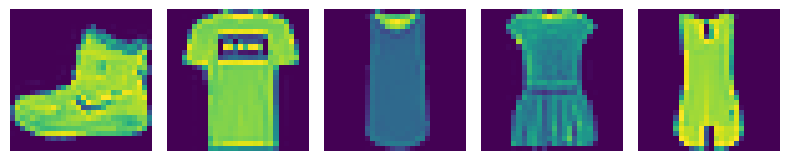

In [5]:
def view_images(images):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(8, 8))

    for i, img in enumerate(images):
        # img = Image.open(images[i])
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Load the first 5 images in a list
images = [img for img in X_train[0:5]]
view_images(images)

## Defining and training the Variational AutoEncoder Neural Network - Notice the similarity with Conventional AutoEncoder

### Defining the Encoder

In [6]:
# Define the architecture of the convolutional autoencoder
input_shape = (28, 28, 1)

# Latent Space Dimension
latent_dim = 2

# Encoder

# Input Layer
encoder_input = Input(shape=input_shape)

# 1st hidden layer - convolutional with 16 filters of size 3x3
encoder_hidden = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder_input)

# 2nd hidden layer - Max Pooling with a 2x2 window
encoder_hidden = MaxPooling2D((2, 2), padding='same')(encoder_hidden)

# 3rd hidden layer - convolutional with 8 filters of size 3x3
encoder_hidden = Conv2D(8, (3, 3), activation='relu', padding='same')(encoder_hidden)

# 4th hidden layer  - Max Pooling with a 2x2 window
encoder_hidden = MaxPooling2D((2, 2), padding='same')(encoder_hidden)

# 5th hidden layer - convolutional with 4 filters of size 3x3
encoder_hidden = Conv2D(4, (3, 3), activation='relu', padding='same')(encoder_hidden)

# 6th hidden layer  - Max Pooling with a 2x2 window
encoder_hidden = MaxPooling2D((2, 2), padding='same', name='encoder_output')(encoder_hidden)

# 7th hidden layer - Flattening the output for inputs to mean and SD Layer
encoder_hidden = Flatten()(encoder_hidden)

### Defining the Latent Vectors

Notice how **z_mean and z_log_var** are just **regular "Dense" layers** and do not actually use any activations to calculate Mean and Log Variance. **These are learnt vectors and KL Divergence regularizes the distribution from the "latent_space" layer to be close to Gaussian (prior), and thereby regularizing z_mean and z_log_var to represent the parameters of this distribution.**

Also notice that the second layer is a "log variance" layer and not "standard deviation" layer.
Using log variance instead of standard deviation in Variational Autoencoders (VAEs) ensures numerical stability during training. Small values of standard deviation can cause numerical issues, whereas the log variance has a wider numerical range.
Log Variance is however converted to Standard Deviation in the "reparameterization trick".

Notice the layers here and compare these with the mathematical representations:

**μ(X) = Wμ * h + bμ**

**log(σ^2(X)) = Wσ * h + bσ;**


In [7]:
# Two Dense Layers representing Mean and Log Variance Vectors
z_mean = Dense(latent_dim, name='z_mean')(encoder_hidden)
z_log_var = Dense(latent_dim, name='z_log_var')(encoder_hidden)

### Reparameterization Trick for Latent Space Generation using Sampling

Compare the Latent Vector Generation here with the formulation studied before:

**Latent Vector (V) = Mean (μ) + (Random Vector (Z) x Standard Deviation (σ))**

where **μ = z_mean, Z = epsilon and σ = standard_deviation and calculated using σ = exp(0.5 * z_log_var)**

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    standard_deviation = tf.exp(0.5 * z_log_var)
    return z_mean + standard_deviation * epsilon

# Lambda Layer to execute the sampling function
latent_space = Lambda(sampling, name='z')([z_mean, z_log_var])

### Combining Latent Vector Layers with Encoder's core architecture

In [9]:
encoder = Model(encoder_input, latent_space, name='encoder')

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 16)           160       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 14, 14, 8)            1160      ['max_pooling2d[0][0]'] 

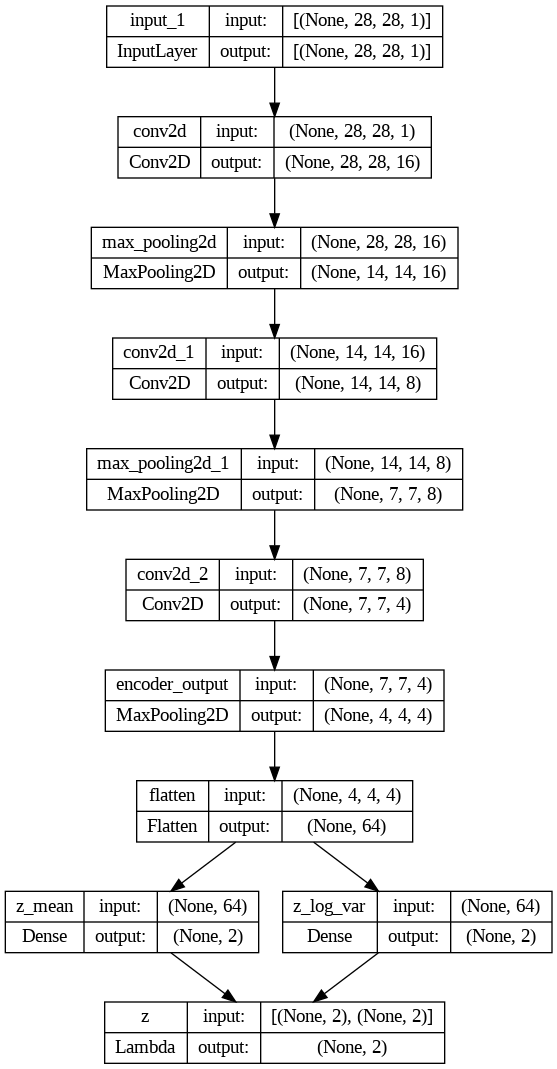

In [10]:
plot_model(encoder, to_file='encoder_architecture.png', show_shapes=True)

### Defining the Decoder - Notice that the layer scheme is reverse of encoder

In [11]:
# Decoder

# Input Layer to decoder
decoder_input = Input(shape=(latent_dim,))

# 1st hidden layer - Dense Layer
decoder_hidden = Dense(7 * 7 * 64, activation='relu')(decoder_input)

# 2nd hidden layer - Reshape Layer
decoder_hidden = Reshape((7, 7, 64))(decoder_hidden)

# 3rd hidden layer - convolutional with 4 filters of size 3x3
decoder_hidden = Conv2D(4, (3, 3), activation='relu', padding='same', name='decoder_input')(decoder_hidden)

# 4th hidden layer - Upsampling rows and columns with Factor 2
decoder_hidden = UpSampling2D((2, 2))(decoder_hidden)

# 5th hidden layer - convolutional with 8 filters of size 3x3
decoder_hidden = Conv2D(8, (3, 3), activation='relu', padding='same')(decoder_hidden)

# 6th hidden layer - Upsampling rows and columns with Factor 2
decoder_hidden = UpSampling2D((2, 2))(decoder_hidden)

# 7th hidden layer - convolutional with 16 filters of size 3x3
decoder_hidden = Conv2D(16, (3, 3), activation='relu', padding='same')(decoder_hidden)

# Output from Decoder - convolutional with 1 filters of size 3x3
decoder_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoder_output')(decoder_hidden)

decoder = Model(decoder_input, decoder_output, name='decoder')

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 decoder_input (Conv2D)      (None, 7, 7, 4)           2308      
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 4)         0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 8)         296       
                                                           

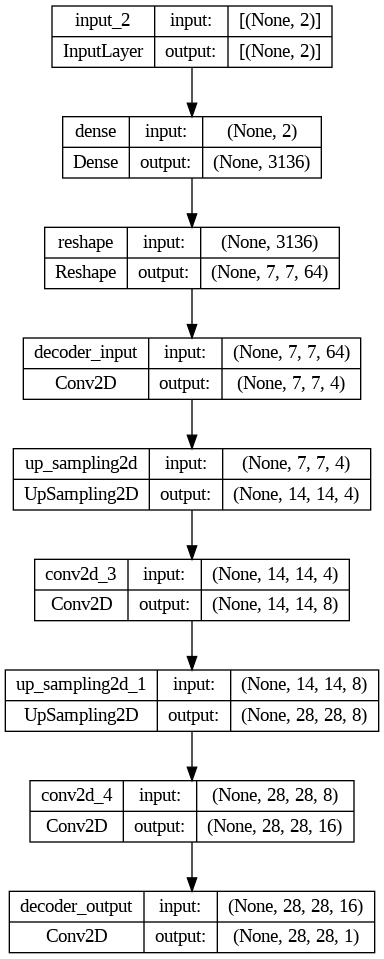

In [14]:
plot_model(decoder, to_file='decoder_architecture.png', show_shapes=True)

### Combine - Encoder and Decoder to form a VAE

In [13]:
# Output from encoder
encoder_output = encoder(encoder_input)

# Output from encoder (latent vector) becomes the input from decoder
decoder_output = decoder(encoder_output)

# Create a model with raw input as input and output from the decoder as output
vae = Model(encoder_input, decoder_output, name='vae')

vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 2)                 1872      
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         13325     
                                                                 
Total params: 15197 (59.36 KB)
Trainable params: 15197 (59.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Defining the Loss Function

The VAE loss consists of two components: Reconstruction Loss and KL divergence. The following custom loss function calculates the same.

**Notice the use of reconstruction_loss_factor**. The reconstruction loss generated is a few orders of magnitude smaller than the KL divergence loss, thereby not contributing significantly to the overall loss. Therefore, we use this scaling factor to rescale the reconstruction loss.

In [25]:
!pip install tensorflow==2.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [15]:
def vae_loss(input_image, output_image, zmean, zlog_var):

  reconstruction_loss_factor = 100
  reconstruction_loss = reconstruction_loss_factor * tf.reduce_mean(K.square(input_image-output_image), axis=[1, 2, 3]) # reconstruction loss
  kl_loss = -0.5 * K.sum(1.0 + zlog_var - K.square(zmean) - K.exp(zlog_var), axis=1) # reparameterization loss
  total_loss = reconstruction_loss + kl_loss

  return total_loss

vae.add_loss(vae_loss(encoder_input, decoder_output, z_mean, z_log_var))

### Compiling the VAE Model

In [16]:
# Compile the VAE model
vae.compile(optimizer=keras.optimizers.Adam())

### Now train the model for 20 epochs

In [17]:
# Train the VAE
history = vae.fit(X_train, X_train, batch_size=128, epochs=20, validation_data=(X_test, X_test))

Epoch 1/20
469/469 [==============================] - 13s 12ms/step - loss: 8.2294 - val_loss: 6.6541
Epoch 2/20
469/469 [==============================] - 4s 9ms/step - loss: 6.6248 - val_loss: 6.5932
Epoch 3/20
469/469 [==============================] - 5s 10ms/step - loss: 6.5493 - val_loss: 6.5067
Epoch 4/20
469/469 [==============================] - 4s 8ms/step - loss: 6.5159 - val_loss: 6.5084
Epoch 5/20
469/469 [==============================] - 4s 8ms/step - loss: 6.4974 - val_loss: 6.4450
Epoch 6/20
469/469 [==============================] - 5s 11ms/step - loss: 6.4710 - val_loss: 6.4625
Epoch 7/20
469/469 [==============================] - 4s 8ms/step - loss: 6.4643 - val_loss: 6.4328
Epoch 8/20
469/469 [==============================] - 4s 8ms/step - loss: 6.4633 - val_loss: 6.4422
Epoch 9/20
469/469 [==============================] - 5s 10ms/step - loss: 6.4535 - val_loss: 6.4336
Epoch 10/20
469/469 [==============================] - 4s 8ms/step - loss: 6.4473 - val_loss: 6

### Visualizing the Training and Validation Loss

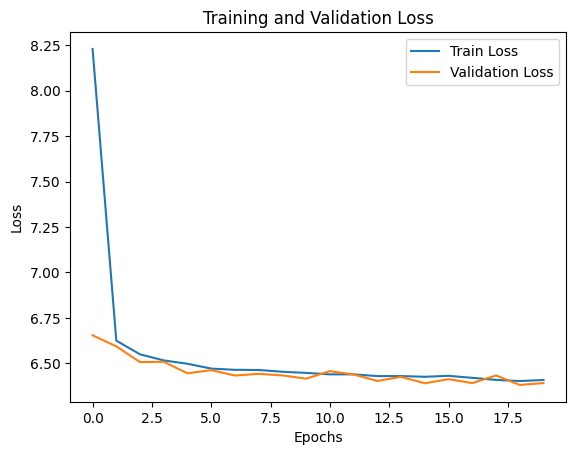

In [18]:
import matplotlib.pyplot as plt

# Obtain the training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curves
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Inference - Visualize 5 random original vs reconstructed images from test dataset

1/1 [==============================] - 0s 18ms/step


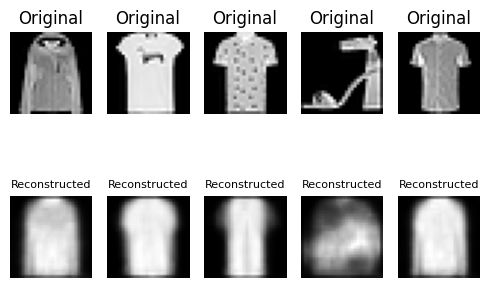

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Select a few random images from the test data for reconstruction
num_images = 5
sample_indices = np.random.choice(len(X_test), num_images, replace=False)
sample_images = X_test[sample_indices]

# Reshape the sample images to match the input shape of the autoencoder
sample_images_reshaped = sample_images.reshape(num_images, 28, 28, 1)

# Reconstruct the sample images using the autoencoder model
reconstructed_images = vae.predict(sample_images_reshaped)

# Plot the original and reconstructed images
plt.figure(figsize=(5, 4))
for i in range(num_images):
    # Original image
    plt.subplot(2, num_images, i + 1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.axis('off')
    plt.title('Original')

    # Reconstruct image
    plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(reconstructed_images[i], cmap='gray')
    plt.axis('off')
    plt.title('Reconstructed', fontsize=8)

plt.tight_layout()
plt.show()

## Now let's generate some new images using **Random Vectors** as input to the decoder. None of the images below are part of the test data, and are "variations" of the training data.

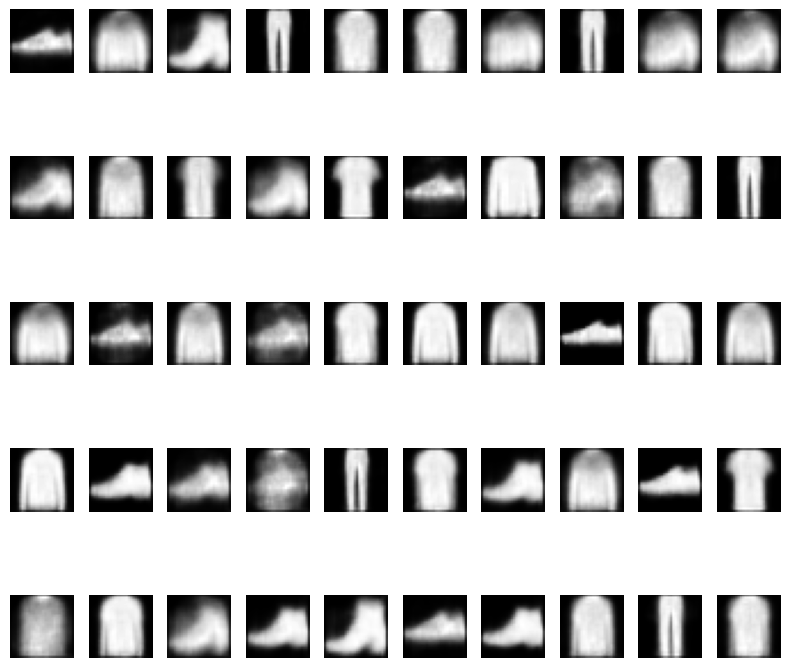

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 50 random vectors
num_vectors = 50
latent_dim = 2  # Assuming a latent space dimension of 2
random_vectors = np.random.randn(num_vectors, latent_dim)

# Generate images using the random vectors
generated_images = decoder(random_vectors)  # Assuming 'decoder' is the VAE decoder function

# Reshape the generated images if needed
generated_images = generated_images.numpy().reshape(num_vectors, 28, 28)

# Display the generated images
fig, axes = plt.subplots(5, 10, figsize=(8, 8))  # Assuming 5 rows and 10 columns for display
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()


## Demonstrating Smooth Interpolation

Similar-looking images across rows and columns in the generated image grid highlight one of the desirable properties of Variational Autoencoders (VAEs), which is the continuity or smoothness of the latent space.

In a VAE, the latent space is typically assumed to follow a multivariate Gaussian distribution. By enforcing the VAE to learn a distribution that approximates a Gaussian, it encourages the latent space to have continuous and smooth transitions.

In the provided code, the grid of samples is generated by evenly spacing points within a defined range in the latent space. Since the latent space is assumed to have a smooth distribution, neighbouring points in the grid are likely to have similar representations, resulting in visually similar decoded images.

This continuity property of the VAE latent space allows for interpolation and smooth transitions between different samples. By linearly interpolating between two latent vectors and decoding the interpolated points, we can observe smooth transformations in the generated output.

(-0.5, 279.5, 279.5, -0.5)

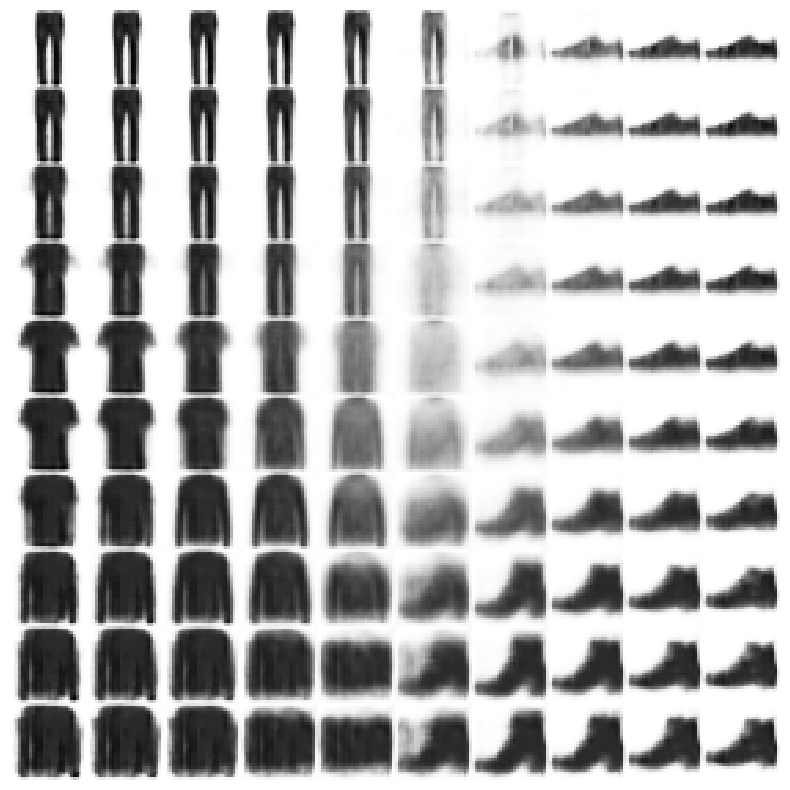

In [22]:
# sample from grid
nx = ny =10
meshgrid = np.meshgrid(np.linspace(-3, 3, nx), np.linspace(-3, 3, ny))
meshgrid = np.array(meshgrid).reshape(2, nx*ny).T
x_grid = decoder(meshgrid)
x_grid = x_grid.numpy().reshape(nx, ny, 28,28, 1)
# fill canvas
canvas = np.zeros((nx*28, ny*28))
for xi in range(nx):
    for yi in range(ny):
        canvas[xi*28:xi*28+28, yi*28:yi*28+28] = x_grid[xi, yi,:,:,:].squeeze()
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(canvas, cmap=plt.cm.Greys)
ax.axis('off')